# <center>Organizaci&oacute;n de Datos</center>
### <center>Críticas cinematográficas TP2: Grupo N°36 - Alan Taylor </center>

### <center>Integrantes:</center>
## <center>Ignacio Sebastián Oviedo</center>
## <center>Santiago Bautista Trezeguet</center>
## <center>Estefano Polizzi</center>

## Importamos librerias y abrimos dataset

In [3]:
#Manipulacion de datos y funciones matemáticas
import pandas as pd
#Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt

#modelos y métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

#preprocesamiento
from sklearn.preprocessing import LabelEncoder

#Metricas para evaluar modelos
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV


#Modelos
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier  
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.layers import Embedding, LSTM, Dense, Dropout

#Limpieza texto
import re
from unidecode import unidecode
from nltk.corpus import stopwords

#nltk.download('stopwords')

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import joblib
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

data = pd.read_csv('./Datasets/train.csv')
data_test = pd.read_csv('./Datasets/test.csv')

# Preprocesamiento del dataset

### Observamos las columnas del dataset

In [220]:
data.dtypes.reset_index()

,index,0
0,ID,int64
1,review_es,object
2,sentimiento,object


### Comenzamos a aplicar tecnicas a las reviews, para simplificar el entrenamiento al modelo

##### Limpiamos las reviews de caracteres no deseados, signos y/o numeros

In [192]:
def transformar(X):
        cleaned_text = []
        for text in X:
            # Eliminar frases entre comillas
            text = re.sub(r'"[^"]+"', '', text)
            text = remplazo_por_comas(text)
            # Convertir a minúsculas y eliminar caracteres no alfabéticos
            text = re.sub(r'[^a-zA-Z, ]', ' ', unidecode(text))
            text = cleanEspacios(text)
            text = cleanMayus(text)
            cleaned_text.append(text)
        return cleaned_text

def cleanEspacios(text):
    res = []
    for c in text:
        if c == ",":
            c = ", "
        res.append(c)
    text = "".join(res)
    return text

def cleanMayus(text):
    words = text.split(' ')
    res = []
    for word in words:
        if len(word) > 1 and word[0].isupper() and word[1].islower():
            word = word.lower()
        res.append(word)
    text = " ".join(res)
    return text

def remplazo_por_comas(text):
    characters_to_replace = ".!?:;-"
    for char in characters_to_replace:
        text = re.sub(re.escape(char), ',', text)
    return text

In [193]:
# Ahora limpiamos las reviews
data['review_es'] = transformar(data['review_es'])

data_test['review_es'] = transformar(data_test['review_es'])

data.head()

,ID,review_es,sentimiento
0,0,uno de los otros criticos ha mencionado que de...,positivo
1,1,"una pequena pequena produccion, la tecnica de ...",positivo
2,2,pense que esta era una manera maravillosa de p...,positivo
3,3,"basicamente, hay una familia donde un nino pe...",negativo
4,4,el de petter mattei es una pelicula visualmen...,positivo


In [194]:
data['review_es'][0]

'uno de los otros criticos ha mencionado que despues de ver solo   oz episodio,  estara enganchado,  tienen razon,  ya que esto es exactamente lo que sucedio conmigo,  la primera cosa que me golpeo sobre oz fue su brutalidad y sus escenas de violencia inconfiadas,  que se encuentran a la derecha de la palabra,  confia en mi,  este no es un espectaculo para los debiles de corazon o timido,  este espectaculo no extrae punzones con respecto a las drogas,  el sexo o la violencia,  es hardcore,  en el uso clasico de la palabra,  se llama OZ,  ya que es el apodo dado al penitenciario del estado de seguridad maximo de oswald,  se centra principalmente en la ciudad de emeralda,  una seccion experimental de la prision donde todas las celulas tienen frentes de vidrio y se enfrentan hacia adentro,  por lo que la privacidad no es alta en la agenda,  em city es el hogar de muchos , , ,  fariarios,  musulmanes,  gangstas,  latinos,  cristianos,  italianos,  irlandeses y mas , , ,  asi que las esposa

##### Borramos las palabras vacias

In [195]:
def remove_stopwords(lista):
    cleaned_reviews = []
    stop_words = set(stopwords.words('spanish'))
    #stop_words.remove('no')
    for text in lista:
        words = text.split()
        cleaned_words = [word for word in words if word not in stop_words]
        cleaned_text = ' '.join(cleaned_words)
        cleaned_reviews.append(cleaned_text)
    return cleaned_reviews

def oracion_negativa(lista):
    res = []
    for text in lista:
        nuevo_texto = []
        oraciones = text.split(',')
        for oracion in oraciones:
            palabras = oracion.split()  # Dividir la oración en palabras
            nueva_oracion = []
            negacion_activa = False  # Bandera para indicar si la negación está activa
            for palabra in palabras:
                if 'no' in palabra.lower():
                    negacion_activa = True
                    palabra = 'NO_' + palabra
                elif negacion_activa:
                    palabra = 'NO_' + palabra
                nueva_oracion.append(palabra)
            nueva_oracion = ' '.join(nueva_oracion)
            nuevo_texto.append(nueva_oracion)
        text = ','.join(nuevo_texto)
        res.append(text)
    return res


#data['review_es'] = oracion_negativa(data['review_es'])

#data_test['review_es'] = oracion_negativa(data_test['review_es'])

data['review_es'] = remove_stopwords(data['review_es'])

data_test['review_es'] = remove_stopwords(data_test['review_es'])


In [196]:
data.head()

,ID,review_es,sentimiento
0,0,criticos mencionado despues ver solo oz episod...,positivo
1,1,"pequena pequena produccion, tecnica filmacion ...",positivo
2,2,pense manera maravillosa pasar tiempo fin sema...,positivo
3,3,"basicamente, familia nino pequeno jake piensa ...",negativo
4,4,petter mattei pelicula visualmente impresionan...,positivo


In [197]:
print(data['review_es'][16])

peliculas simplemente deben ser rehacciones, ellos, si mismo mala pelicula, puede capturar sabor terror pelicula mismo titulo, liam neeson excelente, siempre es, mayor parte reparto detiene, excepcion owen wilson, simplemente trajo sensacion correcta caracter luke, falla importante version desvio demasiado lejos historia shirley jackson intentos ser grandiosos perdio parte emocion pelicula anterior compensacion efectos especiales mas suaves, vez mas, dire si mismo mala pelicula, disfrutaras friccion terror version anterior mas,


# Creamos conjunto de test y entrenamiento

In [198]:
x_train, x_test, y_train, y_test = train_test_split(data['review_es'],
                                                    data['sentimiento'],
                                                    test_size=0.3, 
                                                    random_state=30)

In [199]:
sentimiento = {'positivo': 1, 'negativo': 0}

y_train = [sentimiento[s] for s in y_train]

y_test = [sentimiento[s] for s in y_test]

## TfidfVectorizer

In [183]:
tfidf_vectorizer = TfidfVectorizer(max_features=6000, norm='l2')

x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

x_test_tfidf = tfidf_vectorizer.transform(x_test)

In [188]:
tfidf_vectorizer = TfidfVectorizer(max_features=6000, norm='l2')
ds_trabajo_x_tfidf = tfidf_vectorizer.fit_transform(data['review_es'])
data_a_predecir_tfidf = tfidf_vectorizer.transform(data_test['review_es'])
ds_trabajo_y = [sentimiento[s] for s in data['sentimiento']]
sentimiento_bool = {1: 'positivo',0: 'negativo'}

## CountVectorizer

In [13]:
count_vectorizer = CountVectorizer(max_features=5000)

x_train_count = count_vectorizer.fit_transform(x_train)

x_test_count = count_vectorizer.transform(x_test)

In [14]:
count_vectorizer = CountVectorizer(max_features=5000)
ds_trabajo_x_count = count_vectorizer.fit_transform(data['review_es'])
data_a_predecir_count = count_vectorizer.transform(data_test['review_es'])
ds_trabajo_y = [sentimiento[s] for s in data['sentimiento']]
sentimiento_bool = {1: 'positivo',0: 'negativo'}

# Modelos de prediccion

## Bayes Naïve

## Multinomial

In [125]:
multinomial_classifier = MultinomialNB()
multinomial_classifier.fit(x_train_tfidf, y_train)

MultinomialNB()

In [126]:
multinomial_pred = multinomial_classifier.predict(x_test_tfidf)
#Observamos accuracy del modelo
accuracy = accuracy_score(y_test, multinomial_pred)
print("Accuracy:", accuracy)

#Observamos la precision del modelo
precision = precision_score(y_test, multinomial_pred)
print("Precisión:", precision)

#Observamos el recall del modelo
recall = recall_score(y_test, multinomial_pred)
print("Recall:", recall)

#Observamos el F1 Score
f1 = f1_score(y_test, multinomial_pred)
print("F1-Score:", f1)

Accuracy: 0.8333333333333334
Precisión: 0.8235066941297632
Recall: 0.8499867127292055
F1-Score: 0.8365372041323396


#### Buscamos mejores hiperparametros

In [34]:
n=10

params_grid = {'alpha': [0.1, 1, 1.3, 1.5, 1.7, 2],
    'class_prior': [[0.3, 0.4], [0.4, 0.5], [0.2, 0.4], [0.4, 0.6]],
}

folds=10
kfoldcv = StratifiedKFold(n_splits=folds)
multinomial_classifier = MultinomialNB()
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=multinomial_classifier,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

randomcv.fit(x_train_tfidf,y_train)


print(randomcv.best_params_)
print(randomcv.best_score_)

{'class_prior': [0.4, 0.5], 'alpha': 1.7}
0.8437434675577966


In [123]:
multinomial_classifier = MultinomialNB(alpha=1.7, class_prior=[0.3, 0.4])
multinomial_classifier.fit(x_train_tfidf, y_train)

MultinomialNB(alpha=1.7, class_prior=[0.3, 0.4])

In [124]:
multinomial_pred = multinomial_classifier.predict(x_test_tfidf)
#Observamos accuracy del modelo
accuracy = accuracy_score(y_test, multinomial_pred)
print("Accuracy:", accuracy)

#Observamos la precision del modelo
precision = precision_score(y_test, multinomial_pred)
print("Precisión:", precision)

#Observamos el recall del modelo
recall = recall_score(y_test, multinomial_pred)
print("Recall:", recall)

#Observamos el F1 Score
f1 = f1_score(y_test, multinomial_pred)
print("F1-Score:", f1)

Accuracy: 0.8218666666666666
Precisión: 0.7700868016915201
Recall: 0.9194791389848526
F1-Score: 0.8381782945736433


#### Observamos matriz de confusion

Text(50.722222222222214, 0.5, 'True')

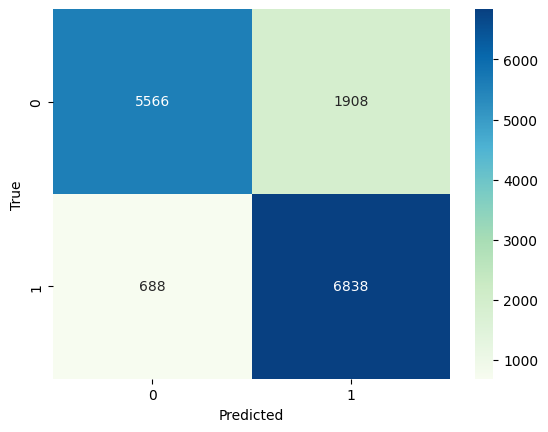

In [35]:
tabla=confusion_matrix(y_test, multinomial_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [189]:
multinomial_classifier = MultinomialNB(alpha=1.7, class_prior=[0.3, 0.4])
multinomial_classifier.fit(ds_trabajo_x_tfidf, ds_trabajo_y)
multinomial_predictions = multinomial_classifier.predict(data_a_predecir_tfidf)
multinomial_predictions = [sentimiento_bool[s] for s in multinomial_predictions]

resultado = pd.DataFrame()
resultado['ID'] = data_test['ID']
resultado['sentimiento'] = multinomial_predictions
#Comento esta linea para que no crear el archivo siempre
resultado.to_csv('predicciones.csv', index=False)

## Bernoulli

In [19]:
bernoulli_model = BernoulliNB()
bernoulli_model.fit(x_train_tfidf, y_train)

BernoulliNB()

In [20]:
bernoulli_model = bernoulli_model.predict(x_test_tfidf)
#Observamos accuracy del modelo
accuracy = accuracy_score(y_test, bernoulli_model)
print("Accuracy:", accuracy)

#Observamos la precision del modelo
precision = precision_score(y_test, bernoulli_model)
print("Precisión:", precision)

#Observamos el recall del modelo
recall = recall_score(y_test, bernoulli_model)
print("Recall:", recall)

#Observamos el F1 Score
f1 = f1_score(y_test, bernoulli_model)
print("F1-Score:", f1)

Accuracy: 0.8318666666666666
Precisión: 0.8251884585391214
Recall: 0.8436088227478076
F1-Score: 0.8342969776609724


#### Buscamos mejores hiperparametros

In [39]:
n=10

params_grid = {'alpha': [0.1, 1, 1.3, 1.5, 1.7, 2],
    'binarize': [0.1, 0.001, 0.2, 0.3],
    'fit_prior': [True, False]
}

folds=10
kfoldcv = StratifiedKFold(n_splits=folds)
bernoulli_model = BernoulliNB()
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=bernoulli_model,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

randomcv.fit(x_train_tfidf,y_train)


print(randomcv.best_params_)
print(randomcv.best_score_)

{'fit_prior': True, 'binarize': 0.001, 'alpha': 1}
0.8398616942424821


In [21]:
bernoulli_model = BernoulliNB(alpha=1, binarize=0.001, fit_prior=True)
bernoulli_model.fit(x_train_tfidf, y_train)

BernoulliNB(alpha=1, binarize=0.001)

In [22]:
bernoulli_pred = bernoulli_model.predict(x_test_tfidf)
#Observamos accuracy del modelo
accuracy = accuracy_score(y_test, bernoulli_pred)
print("Accuracy:", accuracy)

#Observamos la precision del modelo
precision = precision_score(y_test, bernoulli_pred)
print("Precisión:", precision)

#Observamos el recall del modelo
recall = recall_score(y_test, bernoulli_pred)
print("Recall:", recall)

#Observamos el F1 Score
f1 = f1_score(y_test, bernoulli_pred)
print("F1-Score:", f1)

Accuracy: 0.8318666666666666
Precisión: 0.8251884585391214
Recall: 0.8436088227478076
F1-Score: 0.8342969776609724


Text(50.722222222222214, 0.5, 'True')

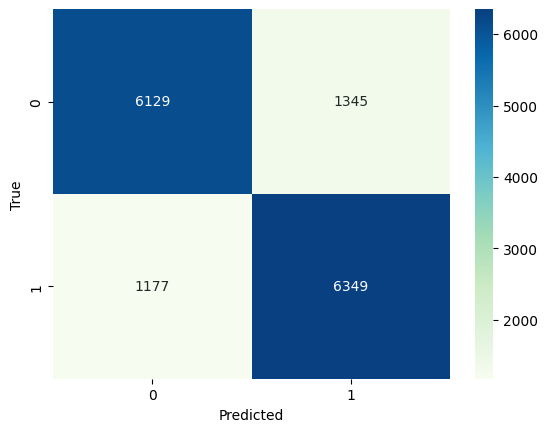

In [23]:
tabla=confusion_matrix(y_test, bernoulli_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [51]:
bernoulli_pred = BernoulliNB(alpha=1, binarize=0.001, fit_prior=True)
bernoulli_pred.fit(ds_trabajo_x_tfidf, ds_trabajo_y)
bernoulli_predictions = bernoulli_pred.predict(data_a_predecir_tfidf)
bernoulli_predictions = [sentimiento_bool[s] for s in bernoulli_predictions]

resultado = pd.DataFrame()
resultado['ID'] = data_test['ID']
resultado['sentimiento'] = bernoulli_predictions
#Comento esta linea para que no crear el archivo siempre
resultado.to_csv('predicciones.csv', index=False)

## XGBoost

In [17]:
xgb_model = XGBClassifier()

xgb_model.fit(x_train_count, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [18]:
xgb_predictions = xgb_model.predict(x_test_count)

#Observamos accuracy del modelo
accuracy = accuracy_score(y_test, xgb_predictions)
print("Accuracy:", accuracy)

#Observamos la precision del modelo
precision = precision_score(y_test, xgb_predictions)
print("Precisión:", precision)

#Observamos el recall del modelo
recall = recall_score(y_test, xgb_predictions)
print("Recall:", recall)

#Observamos el F1 Score
f1 = f1_score(y_test, xgb_predictions)
print("F1-Score:", f1)

Accuracy: 0.8315333333333333
Precisión: 0.8133383477497806
Recall: 0.8620781291522721
F1-Score: 0.836999290459911


#### Buscamos mejores hiperparametros

In [24]:
n=10

params_grid = {'n_estimators':[300, 500, 700, 1000],
                'max_depth':list(range(0,30)),
                'learning_rate':[1, 0.1, 0.01],
                'colsample_bytree':[1, 0.8, 0.5],
                'gamma':[0.8, 0.5, 0.3],
                'objective':["reg:logistic"],
                'random_state':[30, 50, 70]
}

folds=10
kfoldcv = StratifiedKFold(n_splits=folds)
xgb_model = XGBClassifier()
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=xgb_model,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

randomcv.fit(x_train_count,y_train)


print(randomcv.best_params_)
print(randomcv.best_score_)

{'random_state': 30, 'objective': 'reg:logistic', 'n_estimators': 300, 'max_depth': 23, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 1}
0.8548103602119914


In [26]:
xgb_model = XGBClassifier(n_estimators=500,
                          max_depth=13,
                          learning_rate=0.1,
                          subsample=1,
                          colsample_bytree=0.5,
                          gamma=0.2,
                          objective="reg:logistic",
                          random_state=20)

xgb_model.fit(x_train_count, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='reg:logistic', ...)

In [27]:
xgb_predictions = xgb_model.predict(x_test_count)

#Observamos accuracy del modelo
accuracy = accuracy_score(y_test, xgb_predictions)
print("Accuracy:", accuracy)

#Observamos la precision del modelo
precision = precision_score(y_test, xgb_predictions)
print("Precisión:", precision)

#Observamos el recall del modelo
recall = recall_score(y_test, xgb_predictions)
print("Recall:", recall)

#Observamos el F1 Score
f1 = f1_score(y_test, xgb_predictions)
print("F1-Score:", f1)

Accuracy: 0.8520666666666666
Precisión: 0.8413739868776534
Recall: 0.868987509965453
F1-Score: 0.8549578403817243


Text(50.722222222222214, 0.5, 'True')

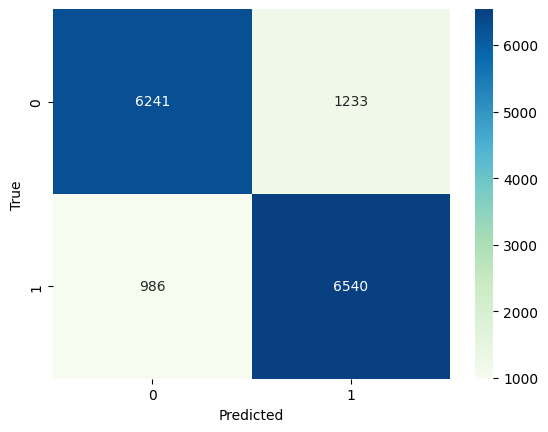

In [28]:
tabla=confusion_matrix(y_test, xgb_predictions)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [20]:
xgb_model = XGBClassifier(n_estimators=500,
                          max_depth=13,
                          learning_rate=0.1,
                          subsample=1,
                          colsample_bytree=0.5,
                          gamma=0.2,
                          objective="reg:logistic",
                          random_state=20)
xgb_model.fit(ds_trabajo_x_count, ds_trabajo_y)
xgb_predictions = xgb_model.predict(data_a_predecir_count)
xgb_predictions = [sentimiento_bool[s] for s in xgb_predictions]

resultado = pd.DataFrame()
resultado['ID'] = data_test['ID']
resultado['sentimiento'] = xgb_predictions
#Comento esta linea para que no crear el archivo siempre
resultado.to_csv('predicciones.csv', index=False)

'xgb_model = XGBClassifier(n_estimators=500,\n                          max_depth=13,\n                          learning_rate=0.1,\n                          subsample=1,\n                          colsample_bytree=0.5,\n                          gamma=0.2,\n                          objective="reg:logistic",\n                          random_state=20)\nxgb_model.fit(ds_trabajo_x_count, ds_trabajo_y)\nxgb_predictions = xgb_model.predict(data_a_predecir_count)\nxgb_predictions = [sentimiento_bool[s] for s in xgb_predictions]\n\nresultado = pd.DataFrame()\nresultado[\'ID\'] = data_test[\'ID\']\nresultado[\'sentimiento\'] = xgb_predictions\n#Comento esta linea para que no crear el archivo siempre\nresultado.to_csv(\'predicciones.csv\', index=False)'

## Random Forest

In [26]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train_count, y_train)

RandomForestClassifier()

In [28]:
rf_predictions = rf_model.predict(x_test_count)
ds_resultados=pd.DataFrame(zip(y_test, rf_predictions),columns=['test','pred'])

#Observamos accuracy del modelo
accuracy = accuracy_score(y_test, rf_predictions)
print("Accuracy:", accuracy)

#Observamos la precision del modelo
precision = precision_score(y_test, rf_predictions)
print("Precisión:", precision)

#Observamos el recall del modelo
recall = recall_score(y_test, rf_predictions)
print("Recall:", recall)

#Observamos el F1 Score
f1 = f1_score(y_test, rf_predictions)
print("F1-Score:", f1)

Accuracy: 0.8225333333333333
Precisión: 0.8294500135464644
Recall: 0.8135795907520595
F1-Score: 0.8214381540112691


#### Buscamos mejores hiperparametros

In [29]:
n=10

params_grid = { 'n_estimators':[550,551,555],
    'bootstrap':[True], 
    'max_depth':[20,25,28],
    'max_features':[20,22,25], 
    'min_samples_split':[2,3,4], 
    'min_samples_leaf':[1,2,3], 
    'random_state':[65,71,75]
}

folds=10
kfoldcv = StratifiedKFold(n_splits=folds)
rf_model = RandomForestClassifier()
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=rf_model,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

randomcv.fit(x_train_count,y_train)


print(randomcv.best_params_)
print(randomcv.best_score_)

{'random_state': 65, 'n_estimators': 550, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 20, 'max_depth': 25, 'bootstrap': True}
0.846790345452091


In [32]:
rf_model = RandomForestClassifier(n_estimators=550,
                                  bootstrap=True, 
                                  max_depth=25,
                                  max_features=20, 
                                  min_samples_split=2, 
                                  min_samples_leaf=2, 
                                  random_state=65)
rf_model.fit(x_train_count, y_train)

RandomForestClassifier(max_depth=25, max_features=20, min_samples_leaf=2,
                       n_estimators=550, random_state=65)

In [33]:
rf_predictions = rf_model.predict(x_test_count)
ds_resultados=pd.DataFrame(zip(y_test, rf_predictions),columns=['test','pred'])

#Observamos accuracy del modelo
accuracy = accuracy_score(y_test, rf_predictions)
print("Accuracy:", accuracy)

#Observamos la precision del modelo
precision = precision_score(y_test, rf_predictions)
print("Precisión:", precision)

#Observamos el recall del modelo
recall = recall_score(y_test, rf_predictions)
print("Recall:", recall)

#Observamos el F1 Score
f1 = f1_score(y_test, rf_predictions)
print("F1-Score:", f1)

Accuracy: 0.8324
Precisión: 0.8066568771414586
Recall: 0.8758968907786341
F1-Score: 0.8398522104726716


#### Observamos matriz de confusion

Text(50.722222222222214, 0.5, 'True')

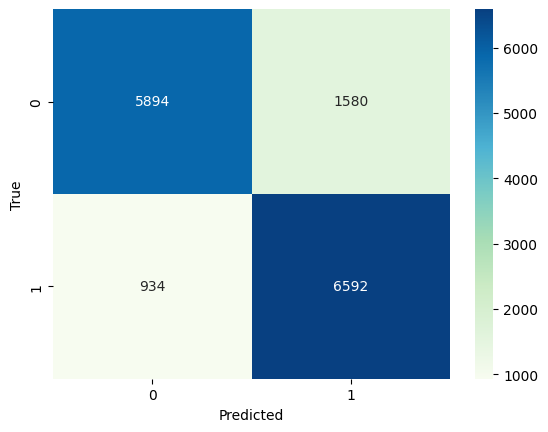

In [34]:
tabla=confusion_matrix(y_test, rf_predictions)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [35]:
rf_model = RandomForestClassifier(n_estimators=550,
                                  bootstrap=True, 
                                  max_depth=25,
                                  max_features=20, 
                                  min_samples_split=2, 
                                  min_samples_leaf=2, 
                                  random_state=65)

rf_model.fit(ds_trabajo_x_count, ds_trabajo_y)
rf_predictions = rf_model.predict(data_a_predecir_count)
rf_predictions = [sentimiento_bool[s] for s in rf_predictions]
resultado = pd.DataFrame()
resultado['ID'] = data_test['ID']
resultado['sentimiento'] = rf_predictions
resultado.to_csv('predicciones.csv', index=False)

## Logistic Regression

In [16]:
lg_model = LogisticRegression()

lg_model.fit(x_train_tfidf, y_train)

LogisticRegression()

In [17]:
lg_predictions = lg_model.predict(x_test_tfidf)
ds_resultados=pd.DataFrame(zip(y_test, lg_predictions),columns=['test','pred'])

#Observamos accuracy del modelo
accuracy = accuracy_score(y_test, lg_predictions)
print("Accuracy:", accuracy)

#Observamos la precision del modelo
precision = precision_score(y_test, lg_predictions)
print("Precisión:", precision)

#Observamos el recall del modelo
recall = recall_score(y_test, lg_predictions)
print("Recall:", recall)

#Observamos el F1 Score
f1 = f1_score(y_test, lg_predictions)
print("F1-Score:", f1)

Accuracy: 0.8646666666666667
Precisión: 0.8523980507822518
Recall: 0.8832048897156524
F1-Score: 0.8675280605586009


#### Buscamos mejores hiperparametros

In [19]:
n=10

params_grid = { 'C': [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

folds=10
kfoldcv = StratifiedKFold(n_splits=folds)
lg_model = LogisticRegression()
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=lg_model,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

randomcv.fit(x_train_tfidf,y_train)


print(randomcv.best_params_)
print(randomcv.best_score_)

/home/estefano/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/estefano/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/estefano/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_i

{'C': 0.9}
0.8773775745655781


In [36]:
lg_model = LogisticRegression(C=0.9)

lg_model.fit(x_train_tfidf, y_train)

LogisticRegression(C=0.9)

In [37]:
lg_predictions = lg_model.predict(x_test_tfidf)
ds_resultados=pd.DataFrame(zip(y_test, lg_predictions),columns=['test','pred'])

#Observamos accuracy del modelo
accuracy = accuracy_score(y_test, lg_predictions)
print("Accuracy:", accuracy)

#Observamos la precision del modelo
precision = precision_score(y_test, lg_predictions)
print("Precisión:", precision)

#Observamos el recall del modelo
recall = recall_score(y_test, lg_predictions)
print("Recall:", recall)

#Observamos el F1 Score
f1 = f1_score(y_test, lg_predictions)
print("F1-Score:", f1)

Accuracy: 0.8646666666666667
Precisión: 0.8520368946963874
Recall: 0.8837363805474355
F1-Score: 0.8675971823636839


Text(50.722222222222214, 0.5, 'True')

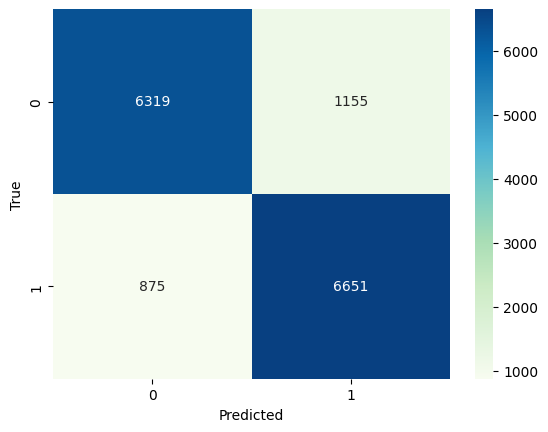

In [38]:
tabla=confusion_matrix(y_test, lg_predictions)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [31]:
lg_model = LogisticRegression(C=0.9)
lg_model.fit(ds_trabajo_x_tfidf, ds_trabajo_y)
lg_predictions = lg_model.predict(data_a_predecir_tfidf)
lg_predictions = [sentimiento_bool[s] for s in lg_predictions]

resultado = pd.DataFrame()
resultado['ID'] = data_test['ID']
resultado['sentimiento'] = lg_predictions
#Comento esta linea para que no crear el archivo siempre
resultado.to_csv('predicciones.csv', index=False)

/home/estefano/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Red neuronal

In [9]:
bool_sentimiento = (data['sentimiento'] == 'positivo').astype(int)
x_train, x_test, y_train, y_test = train_test_split(data['review_es'],
                                                    bool_sentimiento,
                                                    test_size=0.3, 
                                                    random_state=30)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)


In [10]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(x_train)
x_train_seq= tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

max_length = max(len(seq) for seq in x_train_seq)
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length, padding='post')

In [12]:
vocab_size = 10000
batch_size = 64
max_length = 1489

modelo = Sequential()
modelo.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length))
modelo.add(LSTM(64, return_sequences=True))
modelo.add(Dropout(0.2))
modelo.add(LSTM(32, return_sequences=True))
modelo.add(Dropout(0.2))
modelo.add(LSTM(16, return_sequences=True))
modelo.add(Dropout(0.2))
modelo.add(Flatten())
modelo.add(Dense(64, activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Dense(1, activation='sigmoid'))

modelo.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])


modelo.fit(x_train_pad, y_train, epochs=3, batch_size=batch_size, validation_split=0.2, verbose=1)

Epoch 1/3
438/438 [==============================] - 646s 1s/step - loss: 0.4264 - accuracy: 0.7948 - val_loss: 0.3435 - val_accuracy: 0.8530
Epoch 2/3
438/438 [==============================] - 640s 1s/step - loss: 0.2425 - accuracy: 0.9075 - val_loss: 0.2790 - val_accuracy: 0.8873
Epoch 3/3
438/438 [==============================] - 672s 2s/step - loss: 0.1719 - accuracy: 0.9349 - val_loss: 0.3146 - val_accuracy: 0.8839


In [258]:
resultados = modelo.evaluate(x_test_pad, y_test)
print(f"Precisión del modelo: {resultados[1]*100:.2f}%")

469/469 [==============================] - 114s 242ms/step - loss: 0.2876 - accuracy: 0.8796
Precisión del modelo: 87.96%


#### Guardamos modelo en un joblib

In [13]:
joblib.dump(modelo.get_weights(), 'pesos_red_neuronal.joblib')

['pesos_red_neuronal.joblib']

In [14]:
pesos_modelo = joblib.load('pesos_red_neuronal.joblib')

# Creamos un nuevo modelo con la misma arquitectura
modelo = Sequential()
modelo.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length))
modelo.add(LSTM(64, return_sequences=True))
modelo.add(Dropout(0.2))
modelo.add(LSTM(32, return_sequences=True))
modelo.add(Dropout(0.2))
modelo.add(LSTM(16, return_sequences=True))
modelo.add(Dropout(0.2))
modelo.add(Flatten())
modelo.add(Dense(64, activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Dense(1, activation='sigmoid'))

# Establecemos los pesos en el nuevo modelo
modelo.set_weights(pesos_modelo)

#### Testeamos

In [261]:
predictions = modelo.predict(x_test_pad)

469/469 [==============================] - 112s 237ms/step


In [262]:
umbral = 0.5
predicciones_binarias = (predictions > umbral).astype(int)

Text(50.722222222222214, 0.5, 'True')

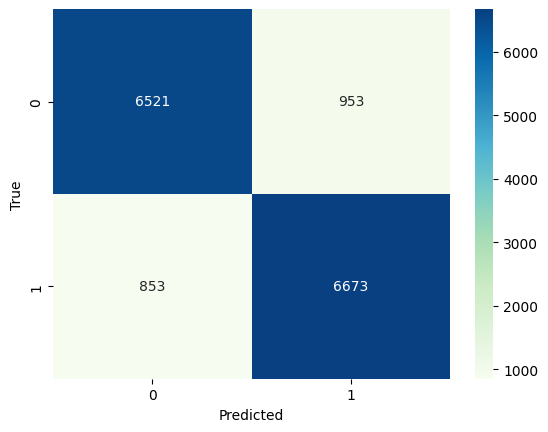

In [263]:
tabla=confusion_matrix(y_test, predicciones_binarias)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [264]:
accuracy = accuracy_score(y_test, predicciones_binarias)
precision = precision_score(y_test, predicciones_binarias)
recall = recall_score(y_test, predicciones_binarias)
f1 = f1_score(y_test, predicciones_binarias)

print("Accuracy:", accuracy)
print("Precisión:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.8796
Precisión: 0.8750327825858903
Recall: 0.8866595801222429
F1-Score: 0.8808078141499471


#### Submit

In [15]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(data_test['review_es'])
data_a_predecir = tokenizer.texts_to_sequences(data_test['review_es'])

#max_length = max(len(seq) for seq in data_a_predecir)
data_a_predecir = pad_sequences(data_a_predecir, maxlen=max_length, padding='post')
red_predictions = modelo.predict(data_a_predecir)

269/269 [==============================] - 67s 246ms/step


In [266]:
def pasar_a_binario(lista):
    l, = lista
    umbral = 0.5
    return ( l > umbral).astype(int)

In [267]:
predicciones = [pasar_a_binario(s) for s in red_predictions]
predicciones = [sentimiento_bool[s] for s in predicciones]

resultado = pd.DataFrame()
resultado['ID'] = data_test['ID']
resultado['sentimiento'] = predicciones
resultado.to_csv('predicciones.csv', index=False)

## Red pre entrenada

In [96]:
from transformers import BertTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def predecir(texto):
    max_length = 512
    texto_truncado = texto[:max_length]
    inputs = tokenizer.encode_plus(texto_truncado,
                                    max_length = 10,
                                    truncation = True,
                                    add_special_tokens = True,
                                    return_token_type_ids = False,
                                    return_attention_mask = True,
                                    return_tensors = 'pt'
                                )
    outputs = model(**inputs)
    logits = outputs.logits
    return logits

#Probamos el modelo pre entrenado
texto_a_predecir = "Este es un buen producto, me encanta."
logits = predecir(texto_a_predecir)
print(logits)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[-0.0035, -0.1839]], grad_fn=<AddmmBackward0>)


#### Hacemos prediccion con conjunto de entrenamiento

In [111]:
def pasar_a_binario(lista):
    l, = lista
    umbral = 0.5
    res = 0
    for elem in l:
        res += elem
    return ((res/5)> umbral).astype(int)

In [112]:
def predecir_texto(texto):
    with torch.no_grad():
        salida = predecir(texto)

        probabilidades = F.sigmoid(salida)

        umbral = 0.5
        prediccion_binaria = (probabilidades > umbral).numpy()

    return prediccion_binaria

def predecir_columna(columna):
    res = []
    for texto in columna:
        predicciones = predecir_texto(texto)
        res.append(predicciones)
    return res

In [89]:
predicciones = predecir_columna(data['review_es'])

sentimiento = {'positivo': 1, 'negativo': 0}
test = [sentimiento[s] for s in data['sentimiento']]

ds_resultados=pd.DataFrame(zip(test, predicciones),columns=['test','pred'])

#Observamos accuracy del modelo
accuracy = accuracy_score(y_test, lg_predictions)
print("Accuracy:", accuracy)

#Observamos la precision del modelo
precision = precision_score(y_test, lg_predictions)
print("Precisión:", precision)

#Observamos el recall del modelo
recall = recall_score(y_test, lg_predictions)
print("Recall:", recall)

#Observamos el F1 Score
f1 = f1_score(y_test, lg_predictions)
print("F1-Score:", f1)

Accuracy: 0.8646666666666667
Precisión: 0.8520368946963874
Recall: 0.8837363805474355
F1-Score: 0.8675971823636839


### Hacemos submit a la competencia

In [113]:
predicciones = predecir_columna(data_test['review_es'])
predicciones = [pasar_a_binario(s) for s in predicciones]
predicciones = [sentimiento_bool[s] for s in predicciones]

resultado = pd.DataFrame()
resultado['ID'] = data_test['ID']
resultado['sentimiento'] = predicciones
#Comento esta linea para que no crear el archivo siempre
resultado.to_csv('predicciones.csv', index=False)

## Ensamble

### Voting

In [14]:
rf_model = RandomForestClassifier(n_estimators=550,
                                  bootstrap=True, 
                                  max_depth=25,
                                  max_features=20, 
                                  min_samples_split=2, 
                                  min_samples_leaf=2, 
                                  random_state=65)

xgb_model = XGBClassifier(n_estimators=500,
                          max_depth=13,
                          learning_rate=0.1,
                          subsample=1,
                          colsample_bytree=0.5,
                          gamma=0.2,
                          objective="reg:logistic",
                          random_state=20)

bernoulli_model = BernoulliNB(alpha=1, binarize=0.001, fit_prior=True)

lg_model = LogisticRegression(C=0.9, max_iter=10000)

multinomial_classifier = MultinomialNB(alpha=1.7, class_prior=[0.4, 0.5])



In [15]:
ensemble_model = VotingClassifier(estimators=[('lg', lg_model), ('multi', multinomial_classifier), ('bern', bernoulli_model)], voting='hard')    

ensemble_model.fit(x_train_tfidf, y_train)

VotingClassifier(estimators=[('lg', LogisticRegression(C=0.9, max_iter=10000)),
                             ('multi',
                              MultinomialNB(alpha=1.7, class_prior=[0.4, 0.5])),
                             ('bern', BernoulliNB(alpha=1, binarize=0.001))])

In [16]:
ensemble_predictions = ensemble_model.predict(x_test_tfidf)  
ds_resultados=pd.DataFrame(zip(y_test, ensemble_predictions),columns=['test','pred'])

#Observamos accuracy del modelo
accuracy = accuracy_score(y_test, ensemble_predictions)
print("Accuracy:", accuracy)

#Observamos la precision del modelo
precision = precision_score(y_test, ensemble_predictions)
print("Precisión:", precision)

#Observamos el recall del modelo
recall = recall_score(y_test, ensemble_predictions)
print("Recall:", recall)

#Observamos el F1 Score de este arbol
f1 = f1_score(y_test, ensemble_predictions)
print("F1-Score:", f1)

Accuracy: 0.8455333333333334
Precisión: 0.8184374617923952
Recall: 0.8894499069891044
F1-Score: 0.8524673670805477


Text(50.722222222222214, 0.5, 'True')

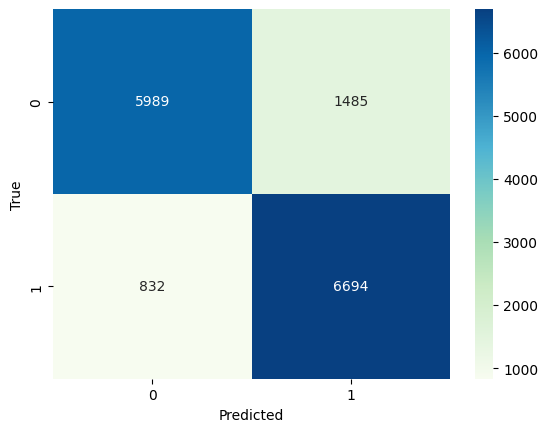

In [17]:
tabla=confusion_matrix(y_test, ensemble_predictions)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [18]:
ensemble_model = VotingClassifier(estimators=[('lg', lg_model), ('multi', multinomial_classifier), ('bern', bernoulli_model)], voting='hard')     
ensemble_model.fit(ds_trabajo_x_tfidf, ds_trabajo_y)
ensemble_predictions = ensemble_model.predict(data_a_predecir_tfidf)
ensemble_predictions = [sentimiento_bool[s] for s in ensemble_predictions]

resultado = pd.DataFrame()
resultado['ID'] = data_test['ID']
resultado['sentimiento'] = ensemble_predictions
#Comento esta linea para que no crear el archivo siempre
resultado.to_csv('predicciones.csv', index=False)

### Stacking

In [12]:
rf_model = RandomForestClassifier(n_estimators=550,
                                  bootstrap=True, 
                                  max_depth=25,
                                  max_features=20, 
                                  min_samples_split=2, 
                                  min_samples_leaf=2, 
                                  random_state=65)

xgb_model = XGBClassifier(n_estimators=500,
                          max_depth=13,
                          learning_rate=0.1,
                          subsample=1,
                          colsample_bytree=0.5,
                          gamma=0.2,
                          objective="reg:logistic",
                          random_state=20)

multinomial_classifier = MultinomialNB(alpha=1.7, class_prior=[0.4, 0.5])

base_models = [
    ('xgb', xgb_model),
    ('multi', multinomial_classifier),
    ('rf', rf_model)
]

In [16]:
meta_model = LogisticRegressionCV(class_weight=None,
                                  penalty='l2',
                                  solver='sag',
                                  random_state=30,
                                  max_iter=10000
                                  )

stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=15,
                                    verbose=2)

In [17]:
#Evaluo en conjunto de test
stacking_model.fit(x_train_tfidf,y_train)
st_predictions = stacking_model.predict(x_test_tfidf)
ds_resultados=pd.DataFrame(zip(y_test, st_predictions),columns=['test','pred'])

#Observamos accuracy del modelo
accuracy = accuracy_score(y_test, st_predictions)
print("Accuracy:", accuracy)

#Observamos la precision del modelo
precision = precision_score(y_test, st_predictions)
print("Precisión:", precision)

#Observamos el recall del modelo
recall = recall_score(y_test, st_predictions)
print("Recall:", recall)

#Observamos el F1 Score
f1 = f1_score(y_test, st_predictions)
print("F1-Score:", f1)

/home/estefano/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.8265333333333333
Precisión: 0.8200728029121165
Recall: 0.8381610417220303
F1-Score: 0.829018267840715


Text(50.722222222222214, 0.5, 'True')

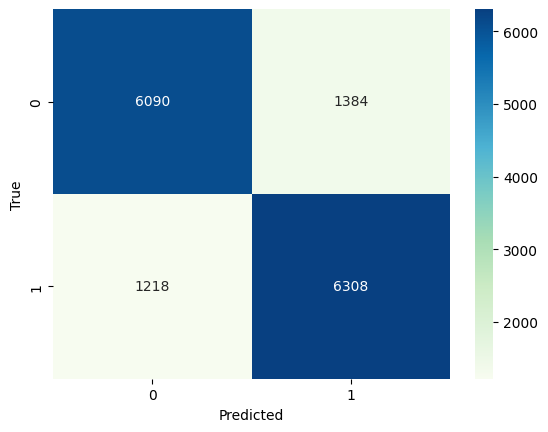

In [18]:
tabla=confusion_matrix(y_test, st_predictions)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [13]:
meta_model = LogisticRegressionCV(class_weight=None,
                                  penalty='l2',
                                  solver='sag',
                                  random_state=30,
                                  max_iter=10000
                                  )

stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=20,
                                    verbose=2)

stacking_model.fit(ds_trabajo_x_count, ds_trabajo_y)
stacking_predictions = stacking_model.predict(data_a_predecir_count)
stacking_predictions = [sentimiento_bool[s] for s in stacking_predictions]

resultado = pd.DataFrame()
resultado['ID'] = data_test['ID']
resultado['sentimiento'] = stacking_predictions
resultado.to_csv('predicciones.csv', index=False)